# Prepare raw data

In [1]:
import os
import re
import pickle
import pandas as pd
import numpy as np
import sys
from shutil import copy
from pathlib import Path
# https://stackoverflow.com/questions/34478398/import-local-function-from-a-module-housed-in-another-directory-with-relative-im
module_path = os.path.abspath(os.path.join('..'))
if module_path in sys.path:
    sys.path.remove(module_path)
if module_path not in sys.path:
    sys.path.append(module_path)
from data.contour import class_mask_from_contour
from data.maps_utils import map_from_binary_masks, smallest_box, compute_pta, resize_class_map, image_from_onehot

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

In this notebook we show and explain how we prepare the data.

The structure of the fodler `raw-dataset` is as follows:
```
dicom/
jpg/
segmentation/
df_info.pick
```

Thus, it doesn't contain anthing but the original data. Particularlly, the class maps are not present in the raw folder.

From now on, we assume that GT segmentations have already been generated and transformed to countour files using the pickle generated in [01_read_excel_files.ipynb](./01_read_excel_files.ipynb) and the tool QLVTHC (more info in [02_get_data_qlvthc](./02_get_data_qlvthc.ipynb)).

## Reading output of QLVTHC

At first, we red the data generated by the tool QLVTHC:

In [2]:
qlvthc_data_folder = "../../lvnc-dataset/FINAL_OUTPUT/"
df = pd.read_pickle(os.path.join(qlvthc_data_folder, "df.pick"))

In [3]:
df

,patient,slice,set,reversed,score,pta_qlvthc
0,ANH,4,Hebron,False,5.0,41.98
1,ANH,5,Hebron,False,5.0,42.02
2,ANH,6,Hebron,False,4.5,42.78
3,ANH,7,Hebron,False,4.5,38.60
4,ANH,8,Hebron,False,5.0,37.26
...,...,...,...,...,...,...
3077,X9,4,X,False,5.0,35.32
3078,X9,5,X,False,5.0,30.86
3079,X9,6,X,False,5.0,26.88
3080,X9,7,X,False,5.0,25.68


## Parsing contour files

Now we test whether the class map generation is correct with some random examples, and it looks like it works perfectly.

P185 5


/home/jesus/deep-learning-lvnc/data/contour.py:62: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  CTIcontours_np = np.array([np.array(xi) for xi in CTIcontours])#, dtype=object)


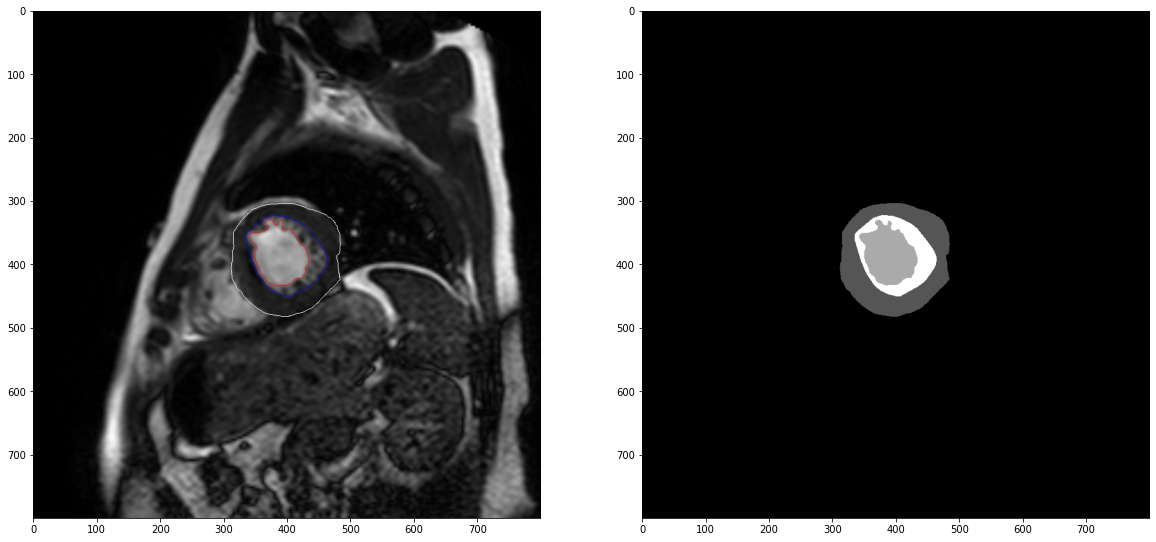

P239 5


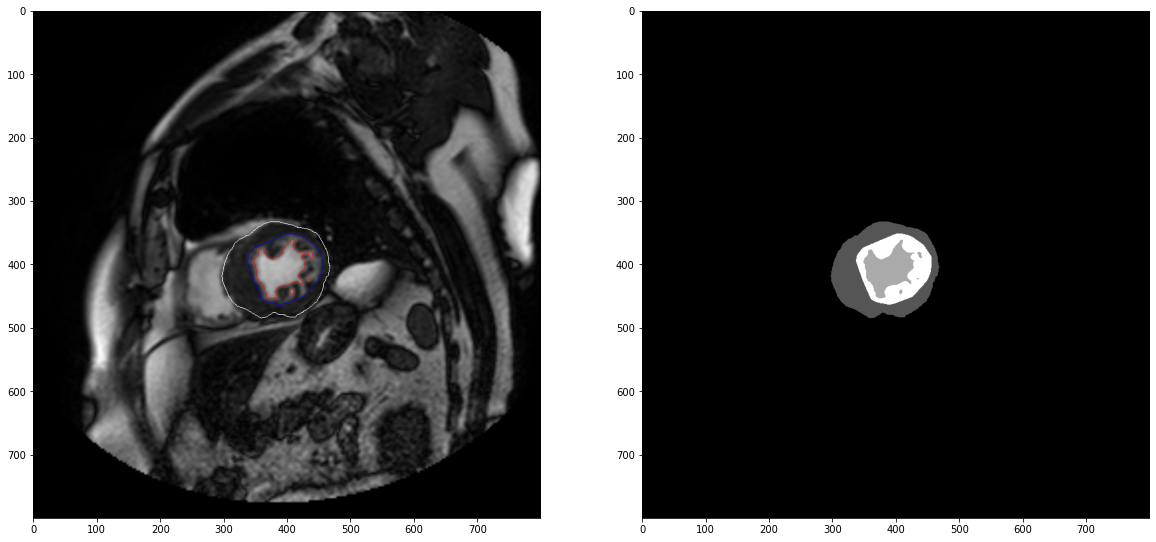

X62 6


/home/jesus/deep-learning-lvnc/data/contour.py:61: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  CTIpoints = np.array([[np.array(xi) for xi in CTIpoints]])


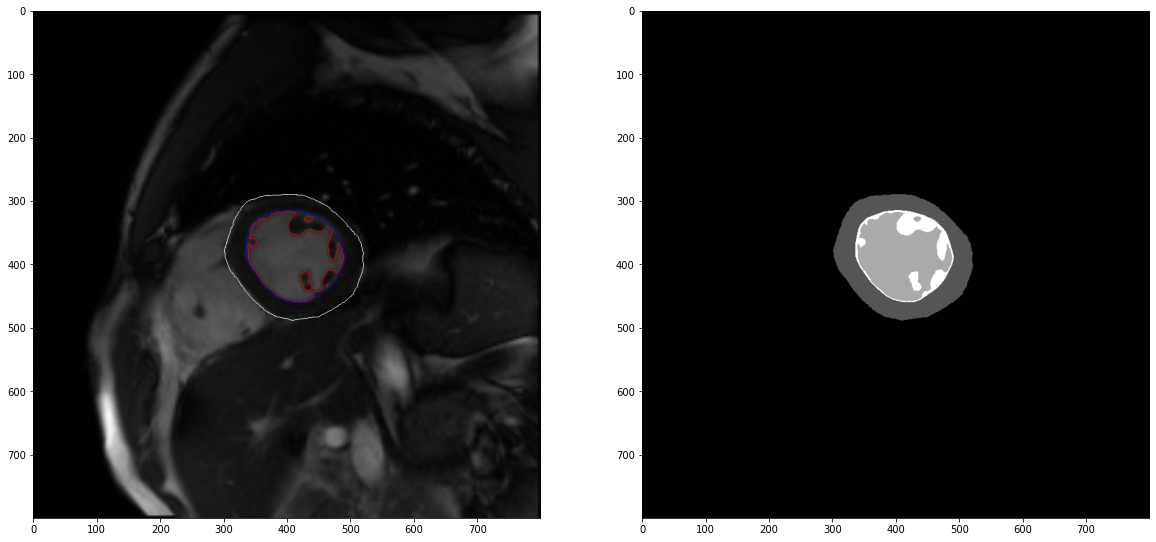

P125 7


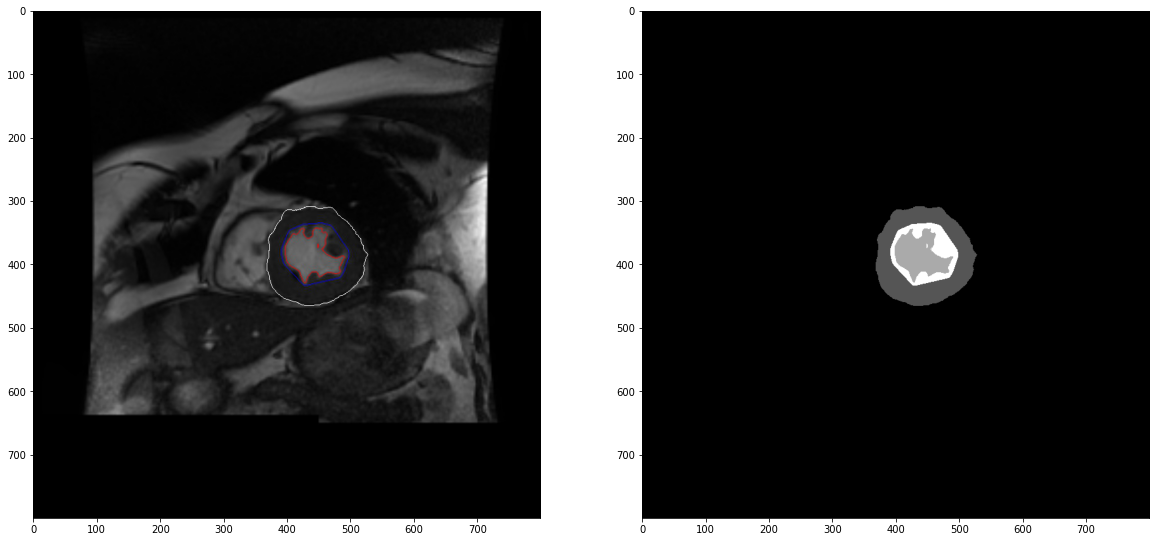

P287 7


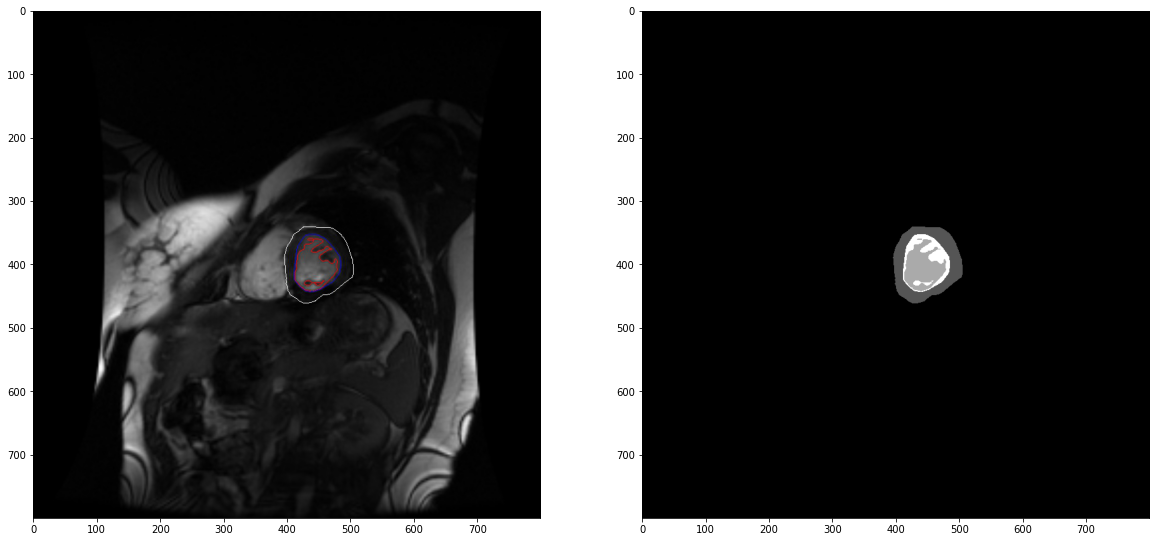

In [4]:
df_test = df.sample(n=5)
    
plt.rcParams['figure.figsize'] = [10, 5]
for i, row in df_test.iterrows():
    print(row["patient"], row["slice"])
    img = mpimg.imread(os.path.join(qlvthc_data_folder, f"{row['patient']}_{row['slice']}_output.jpg"))
    #plt.imshow(img1)
    plt.show()
    cont = map_from_binary_masks(class_mask_from_contour(os.path.join(qlvthc_data_folder, f"{row['patient']}_{row['slice']}.cont")))
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20, 10))
    axes[0].imshow(img)
    axes[1].imshow(cont, cmap='gray')
    #plt.imshow(img2)
    plt.show()

## Some problematic slices

The ground truth generated for some slices (especially basal slices) does not seem good enough, so I think that the best option is removing them.

My main concern in most of the images showed below is that the borders include tissue that does not belong to the left ventricle.

More info: https://www.researchgate.net/figure/Basal-short-axis-slice-selection-for-the-left-ventricle-Illustration-of-the-basal-plane_fig3_299369791

In [5]:
bad_slices = [
    ("P161", 11),
    ("P163", 9),
    ("P168", 11),
    ("P168", 12),
    ("P177", 12),
    ("P180", 10),
    ("P187", 10),
    ("P189", 9),
    ("P189", 10),
    ("P194", 9),
    ("P195", 10),
    ("P198", 9),
    ("P199", 1),
    ("P199", 2),
    ("P202", 10),
    ("P206", 10),
    ("P208", 12),
    ("P209", 1),
    ("P214", 10),
    ("P218", 11),
    ("P222", 10),
    ("P224", 8),
    ("P237", 10),
    ("P239", 9),
    ("P239", 10),
    ("P248", 9),
    ("P255", 11),
    #("P259", 2),
    ("P264", 9),
    #("P271", 11), ("P272", 11),
    ("P274", 6),
    ("P274", 10),
    ("P278", 9),
    ("P279", 10),
    ("P280", 10),
    ("P289", 11),
    #("P290", 9),
    ("P290", 9),
    ("X8", 5),
    #("X30", 8),
    ("X42", 9),
    ("X42", 10),
]

In [6]:
#!pip install ipyplot
import ipyplot

image_paths = [os.path.join(qlvthc_data_folder, f"{p}_{s}_output.jpg") for p,s in bad_slices]
labels = [f"{p}_{s}" for p,s in bad_slices]

ipyplot.plot_images(image_paths, labels, img_width=400, max_images=len(bad_slices))

In [7]:
df = df[~pd.Series(list(zip(df['patient'], df['slice']))).isin(bad_slices)]

## Creating the raw dataset

It is time to process the whole dataset and add the slices to the raw folder

In [8]:
def add_row_to_raw_dataset(row, output_dir):
    jpg_image = os.path.join(qlvthc_data_folder, f"{row['patient']}_{row['slice']}.jpg")
    dicom_file = os.path.join(qlvthc_data_folder, f"{row['patient']}_{row['slice']}.dcm")
    cont_file = os.path.join(qlvthc_data_folder, f"{row['patient']}_{row['slice']}.cont")

    copy(jpg_image, os.path.join(output_dir,"jpg"))
    copy(dicom_file, os.path.join(output_dir,"dicom"))

    class_map = map_from_binary_masks(class_mask_from_contour(cont_file))
    pta, _, _ = compute_pta(class_map, rh=1, rv=1) # RH y RV no influyen en el cómpute del PTA (se anulan los factores al dividir)
    pickle.dump(class_map, open(os.path.join(output_dir, f"segmentation/{row['patient']}_{row['slice']}.pick"), "wb"))
    return pta[0]

In [9]:
output_dir = "../../LVNC_dataset/raw_dataset/"
Path(os.path.join(output_dir, "jpg")).mkdir(parents=True, exist_ok=True)
Path(os.path.join(output_dir, "dicom")).mkdir(parents=True, exist_ok=True)
Path(os.path.join(output_dir, "segmentation")).mkdir(parents=True, exist_ok=True)


df["pta_class_map"] = df.apply(lambda x: add_row_to_raw_dataset(x, output_dir), axis=1)
df.to_pickle(os.path.join(output_dir, "df_info.pick"))

<ipython-input-9-45547ce416ba>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["pta_class_map"] = df.apply(lambda x: add_row_to_raw_dataset(x, output_dir), axis=1)


In [10]:
df

,patient,slice,set,reversed,score,pta_qlvthc,pta_class_map
0,ANH,4,Hebron,False,5.0,41.98,41.801974
1,ANH,5,Hebron,False,5.0,42.02,41.825516
2,ANH,6,Hebron,False,4.5,42.78,42.629004
3,ANH,7,Hebron,False,4.5,38.60,38.458082
4,ANH,8,Hebron,False,5.0,37.26,37.127519
...,...,...,...,...,...,...,...
3077,X9,4,X,False,5.0,35.32,35.079389
3078,X9,5,X,False,5.0,30.86,30.661447
3079,X9,6,X,False,5.0,26.88,26.719278
3080,X9,7,X,False,5.0,25.68,25.507652


In [11]:
max(abs(df["pta_class_map"]-df["pta_qlvthc"]))

0.918018433179725

In [12]:
np.median(abs(df["pta_class_map"]-df["pta_qlvthc"]))

0.1719147025308576

In [13]:
np.mean(abs(df["pta_class_map"]-df["pta_qlvthc"]))

0.19130249373862174